In [18]:

import torch
import torchvision
from torch import nn 
#from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image 
#%matplotlib inline
import numpy as np
import dataset_utils
import importlib
importlib.reload(dataset_utils)

<module 'dataset_utils' from '/home/fogliodicarta/Desktop/InsectClassification/dataset_utils.py'>

In [19]:
df = pd.read_csv('final_dataset.csv',index_col=0)
tform = transforms.Compose([transforms.Resize((64,64)),transforms.PILToTensor(),transforms.ConvertImageDtype(torch.float),transforms.Normalize(0.5,0.5)])
image_dataset = torchvision.datasets.ImageFolder("image_dataset/",transform=tform)
species2genus = dataset_utils.species_label_to_genus_label(df,image_dataset)
batch_size = 1000 
import random
import dataset_utils
img2dna = dataset_utils.get_imgs_bold_id(image_dataset,df)

nucleotides = df[['nucleotide','species_name','genus_name','processid','image_urls']]
colonna_dna = df.loc[:,"nucleotide"]
nucleotides.loc[:,'nucleotide'] = colonna_dna.apply(dataset_utils.one_hot_encoding)
random.seed(42)

X_train_1, X_test, y_train_1, y_test = dataset_utils.data_split(nucleotides,0.2,random_state=42)
print(y_test)
train_data = X_train_1
train_data['species_name'] = y_train_1

X_train, X_validation, y_train, y_validation = dataset_utils.data_split(train_data,0.2,drop_labels=False,random_state=42)
train_indices, val_indices, test_indices = dataset_utils.image_splits_from_df(X_train,X_validation,X_test,image_dataset)

365    Bembidion normannum
292       Bledius gallicus
321       Praxis edwardsii
352        Andrena pilipes
18     Automeris managuana
              ...         
412         Hemiceras losa
413         Hemiceras losa
417     Hemiceras punctata
418         Hemiceras losa
421     Hemiceras punctata
Name: species_name, Length: 9991, dtype: object


In [20]:
expanded_train_dna_features = torch.load('expanded_train_dna_features.pt')
expanded_train_dna_labels = torch.load('expanded_train_dna_labels.pt')
image_train_features = torch.load('image_train_features.pt')
image_train_labels= torch.load('image_train_labels.pt')
assert((image_train_labels == expanded_train_dna_labels).all())

In [21]:
expanded_val_dna_features = torch.load('expanded_val_dna_features.pt')
expanded_val_dna_labels = torch.load('expanded_val_dna_labels.pt')
image_val_features = torch.load('image_val_features.pt')
image_val_labels= torch.load('image_val_labels.pt')
assert((image_val_labels == expanded_val_dna_labels).all())

In [22]:
complete_train_features = torch.cat((expanded_train_dna_features,image_train_features),dim=1)
complete_val_features = torch.cat((expanded_val_dna_features,image_val_features),dim=1)

In [23]:
expanded_train_dna_features.shape
image_train_features.shape
complete_train_features.shape

torch.Size([13039, 7346])

# Con Forest

In [105]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import LinearSVC,SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier 
clf = RandomForestClassifier(min_samples_leaf=2,n_jobs=-1)
clf = clf.fit(complete_train_features, image_train_labels)

In [106]:

train_predicted_labels = clf.predict(complete_train_features)
val_predicted_labels= clf.predict(complete_val_features)

temp_val_predicted_probs = clf.predict_proba(complete_val_features)
val_predicted_probs = np.zeros((len(temp_val_predicted_probs),1050))
for i, cls in enumerate(np.arange(1050)):
    if cls in clf.classes_:
        val_predicted_probs[:, cls] = temp_val_predicted_probs[:, list(clf.classes_).index(cls)]

# Con Linear Model

In [180]:
class FeatureDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        
    def __getitem__(self, index):
        x = self.data[index]
        y = torch.tensor(self.targets[index],dtype=torch.long)
        return x, y
    
    def __len__(self):
        return len(self.data)
d_train = FeatureDataset(complete_train_features, image_train_labels)
d_val = FeatureDataset(complete_val_features, image_val_labels)

In [181]:
class LinearModel(torch.nn.Module):

    def __init__(self,n_classes=1050):
        super(LinearModel, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(7346,5000),
            nn.BatchNorm1d(5000),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(5000,2000),
            nn.BatchNorm1d(2000),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(2000,1050),
        )
        
    def forward(self, x):
        x = self.main(x)
        #x = nn.functional.softmax(x)
        return x
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
linearmodel = LinearModel().cuda()

dataloader_train = DataLoader(d_train, batch_size=32,shuffle=True)
dataloader_val = DataLoader(d_val, batch_size=32,shuffle=True)
dataloaders = {'train':dataloader_train,'val':dataloader_val}
dataset_sizes = {'train': d_train.data.shape[0], 'val':d_val.data.shape[0]}

In [182]:

from tqdm.notebook import tqdm
def fit(epochs,dataloaders,optimizer,model,start_idx=0):
    criterion = torch.nn.CrossEntropyLoss()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    torch.cuda.empty_cache()
    
    train_losses = []
    train_scores = []
    val_losses = []
    val_scores = []
    for epoch in range(epochs):
        running_train_corrects = 0
        for dnas,labels in tqdm(dataloaders['train']):
            model.train()
            dnas = dnas.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            predicted_labels = model(dnas)
            train_loss = criterion(predicted_labels,labels)
            train_loss.backward()
            optimizer.step()
            
            _, preds = torch.max(predicted_labels, 1)
            #print(preds)
            #print(labels.data)
            running_train_corrects += torch.sum(preds == labels.data)
        train_losses.append(train_loss)
        
        running_val_corrects = 0
        for dnas,labels in tqdm(dataloaders['val']):
            
            model.eval()
            with torch.no_grad():
                dnas = dnas.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                predicted_labels = model(dnas)
                val_loss = criterion(predicted_labels,labels)
                
                _, preds = torch.max(predicted_labels, 1)
                #print(preds)
                #print(labels.data)
                running_val_corrects += torch.sum(preds == labels.data)
        val_losses.append(val_loss)
        
        
        
        #real_scores.append(real_score)
        #fit_p.writer.add_scalar('loss_g', loss_g, epoch)
        # Log losses & scores (last batch)
        
        epoch_train_acc = running_train_corrects.double() / dataset_sizes['train']
        epoch_val_acc = running_val_corrects.double() / dataset_sizes['val']
        print("Epoch [{}/{}], train_loss: {:.4f},  train_score: {:.4f},val_loss: {:.4f},  val_score: {:.4f}".format(
            epoch+1, epochs, train_loss, epoch_train_acc,val_loss,epoch_val_acc))
        #print(f"class accuracy real {class_accuracy_real}")
    
    return train_losses

In [183]:
optimizer = torch.optim.Adam(linearmodel.parameters())
fit(20,dataloaders,optimizer,linearmodel)

  0%|          | 0/408 [00:00<?, ?it/s]

/tmp/ipykernel_33382/3859614125.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(self.targets[index],dtype=torch.long)


  0%|          | 0/218 [00:00<?, ?it/s]

Epoch [1/20], train_loss: 2.3089,  train_score: 0.3107,val_loss: 11.9374,  val_score: 0.2495


  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

Epoch [2/20], train_loss: 1.2046,  train_score: 0.6338,val_loss: 8.0876,  val_score: 0.3530


  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

Epoch [3/20], train_loss: 0.3812,  train_score: 0.8166,val_loss: 11.6902,  val_score: 0.4116


  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

Epoch [4/20], train_loss: 0.1614,  train_score: 0.9089,val_loss: 7.0919,  val_score: 0.4254


  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

Epoch [5/20], train_loss: 0.0220,  train_score: 0.9396,val_loss: 8.1486,  val_score: 0.4377


  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

Epoch [6/20], train_loss: 0.1493,  train_score: 0.9587,val_loss: 8.4002,  val_score: 0.4424


  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

Epoch [7/20], train_loss: 0.0699,  train_score: 0.9561,val_loss: 4.5995,  val_score: 0.4456


  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

Epoch [8/20], train_loss: 0.2102,  train_score: 0.9639,val_loss: 9.5102,  val_score: 0.4451


  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

Epoch [9/20], train_loss: 0.0267,  train_score: 0.9674,val_loss: 8.7544,  val_score: 0.4427


  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

Epoch [10/20], train_loss: 0.0039,  train_score: 0.9636,val_loss: 10.1160,  val_score: 0.4433


  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

Epoch [11/20], train_loss: 0.0739,  train_score: 0.9699,val_loss: 10.9352,  val_score: 0.4457


  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

Epoch [12/20], train_loss: 0.1098,  train_score: 0.9771,val_loss: 8.8778,  val_score: 0.4456


  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

Epoch [13/20], train_loss: 1.0245,  train_score: 0.9742,val_loss: 10.8421,  val_score: 0.4473


  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

Epoch [14/20], train_loss: 0.2690,  train_score: 0.9760,val_loss: 10.4389,  val_score: 0.4472


  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

Epoch [15/20], train_loss: 0.0016,  train_score: 0.9804,val_loss: 9.5740,  val_score: 0.4502


  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

Epoch [16/20], train_loss: 0.0028,  train_score: 0.9788,val_loss: 11.7474,  val_score: 0.4486


  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

Epoch [17/20], train_loss: 0.0092,  train_score: 0.9827,val_loss: 10.1141,  val_score: 0.4496


  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

Epoch [18/20], train_loss: 0.0183,  train_score: 0.9764,val_loss: 12.2227,  val_score: 0.4466


  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

Epoch [19/20], train_loss: 0.2774,  train_score: 0.9803,val_loss: 11.6746,  val_score: 0.4463


  0%|          | 0/408 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

Epoch [20/20], train_loss: 0.4975,  train_score: 0.9821,val_loss: 11.3952,  val_score: 0.4522


[tensor(2.3089, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(1.2046, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.3812, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.1614, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.0220, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.1493, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.0699, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.2102, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.0267, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.0039, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.0739, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.1098, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(1.0245, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.2690, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.0016, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(0.0028, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(

In [184]:
linearmodel.eval()
with torch.no_grad():
    train_predicted_labels = nn.functional.softmax(linearmodel(complete_train_features.cuda())).argmax(dim=1)
    train_predicted_probs = nn.functional.softmax(linearmodel(complete_train_features.cuda())).cpu().numpy()
    train_predicted_labels = train_predicted_labels.cpu().numpy()
    val_predicted_labels = nn.functional.softmax(linearmodel(complete_val_features.cuda())).argmax(dim=1)
    val_predicted_probs = nn.functional.softmax(linearmodel(complete_val_features.cuda())).cpu().numpy()
    val_predicted_labels = val_predicted_labels.cpu().numpy()

/tmp/ipykernel_33382/2108038175.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  train_predicted_labels = nn.functional.softmax(linearmodel(complete_train_features.cuda())).argmax(dim=1)
/tmp/ipykernel_33382/2108038175.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  train_predicted_probs = nn.functional.softmax(linearmodel(complete_train_features.cuda())).cpu().numpy()
/tmp/ipykernel_33382/2108038175.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_predicted_labels = nn.functional.softmax(linearmodel(complete_val_features.cuda())).argmax(dim=1)
/tmp/ipykernel_33382/2108038175.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  val_predicted_probs = nn.functional.softmax

# Accuracies 

In [185]:

print(f"Training species accuracy:{np.count_nonzero(train_predicted_labels==image_train_labels.numpy())/len(image_train_labels)}")



Training species accuracy:0.9962420431014648


In [186]:
print(f"Validation species accuracy:{np.count_nonzero(val_predicted_labels==image_val_labels.numpy())/len(image_val_labels)}")


Validation species accuracy:0.4521926671459382


In [187]:

import math
n_correct_genus = 0
for i in range(len(image_val_labels)):
    #label_best_specie = val_predicted_probs[i].argmax()
    label_best_specie = val_predicted_labels[i]
    assert(val_predicted_labels[i]==val_predicted_probs[i].argmax())
    genus_of_best_species = species2genus[label_best_specie.item()]
    #species_same_genus = [k for k,v in species2genus.items() if v == genus_of_best_species]
    #reduced_species = val_predicted_probs[i][species_same_genus]
    #normalized_reduced_species = reduced_species/(reduced_species.sum())
    
    real_genus = species2genus[image_val_labels[i].item()]
    predicted_genus = genus_of_best_species
    if real_genus == predicted_genus:
        n_correct_genus+=1
print(f"Validation genus accuracy: {n_correct_genus/len(image_val_labels)}")

Validation genus accuracy: 0.796117900790798


In [188]:
def entropy_per_symbol(v):
    if len(v)==1:
        return 0.0
    entropy = 0 
    n_zeros = 0
    for p in v:
        if p != 0:
            entropy-=p*math.log(p,2)
        else:
            n_zeros +=1
    #print(f"n_zeros:{n_zeros}")
    #FORSE VA TOLTO N_ZEROS DALLA LENGTH
    mean_symbol_entropy = entropy/math.log(len(normalized_reduced_species),2)
    return mean_symbol_entropy

In [189]:

described_species_labels = np.array([image_dataset.targets[i] for i in train_indices])
described_species_labels = np.unique(described_species_labels)
tprs = []
fprs = []
correct_genus_rate = []
correct_species_rate = []
for t in range(0,100,1):
    entropy_threshold = t/100.0
    #print(val_predicted_probs.shape)
    n_undescribed_samples = 0
    n_described_samples = 0
    n_correct_undescribed_samples = 0
    n_correct_described_samples = 0
    n_correct_genus = 0 
    n_correct_species = 0 
    for i in range(len(image_val_labels)):
        #label_best_specie = val_predicted_probs[i].argmax()
        label_best_specie = val_predicted_labels[i]
        assert(val_predicted_labels[i]==val_predicted_probs[i].argmax())
        genus_of_best_species = species2genus[label_best_specie.item()]
        species_same_genus = [k for k,v in species2genus.items() if v == genus_of_best_species]
        #print(val_labels[i])
        #print(label_best_specie)
        #print(species_same_genus)
        reduced_species = val_predicted_probs[i][species_same_genus]
        normalized_reduced_species = reduced_species/(reduced_species.sum())
        #print(normalized_reduced_species)
        H_s = entropy_per_symbol(normalized_reduced_species)
        #print(H_s)
        #print("Genus" if H_s > entropy_threshold else "Species")
        #input() 
        if image_val_labels[i].item() in described_species_labels:
            #tn
            n_described_samples +=1
            if H_s < entropy_threshold:
                n_correct_described_samples+=1
                if label_best_specie == image_val_labels[i]:
                    n_correct_species+=1
        else:
            #tp
            n_undescribed_samples+=1
            if H_s >= entropy_threshold:
                n_correct_undescribed_samples+=1
                real_genus = species2genus[image_val_labels[i].item()]
                predicted_genus = genus_of_best_species
                if real_genus == predicted_genus:
                    n_correct_genus+=1
            
        
            
    tprs.append(n_correct_undescribed_samples/n_undescribed_samples)#TPR = recall = sensitivity
    fprs.append(1-n_correct_described_samples/n_described_samples)#1-TNR = 1 - specificity
    correct_genus_rate.append(n_correct_genus/n_undescribed_samples)
    correct_species_rate.append(n_correct_species/n_described_samples)

(0.0, 1.0)

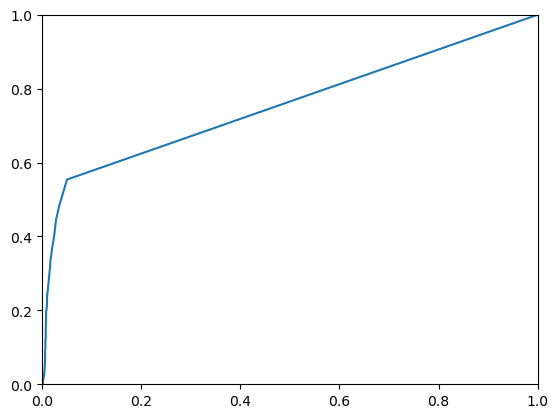

In [190]:

plt.plot(fprs,tprs)
plt.xlim([0, 1])
plt.ylim([0, 1])

In [193]:
print(fprs[5])
print(tprs[5])

0.023191094619666064
0.3872614888470841


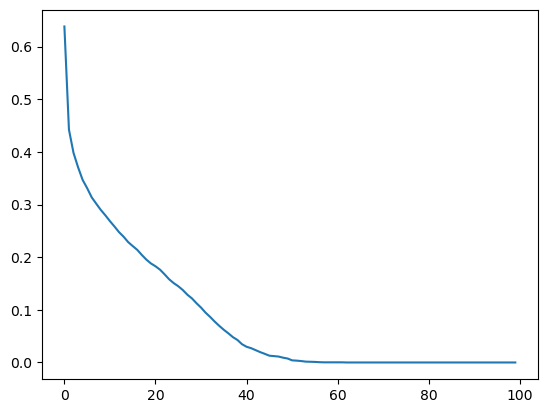

In [194]:

plt.plot(correct_genus_rate)

In [195]:
correct_genus_rate[1]

0.44235420585864016

In [196]:
correct_species_rate[1]

0.9316635745207174

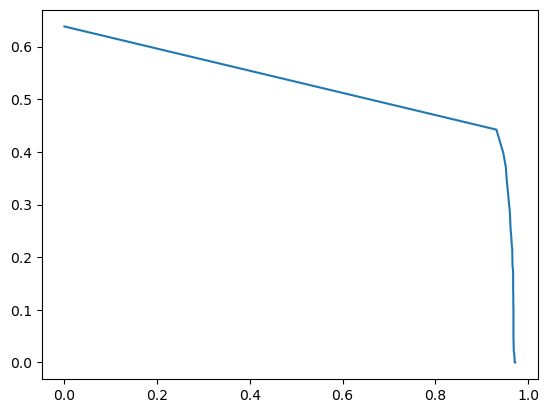

In [197]:
plt.plot(correct_species_rate,correct_genus_rate)
plt.savefig("linearnet")